# Procesamiento de lenguaje natural usando redes neuronales recurrentes.

## Sección 2 - Proyecto (5) - Equipo #4 (T5)
- Alejandro Molina
- Sandro Portanova
- Carlos Fornari

La red implementada en este proyecto es para predecir "la siguiente palabra" en un texto en Español.

## Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Tokenizer se utiliza para convertir el texto en secuencias de enteros
from keras.preprocessing.text import Tokenizer

# Pad_sequences se utiliza para rellenar las secuencias de enteros
from keras.preprocessing.sequence import pad_sequences

# to_categorical se utiliza para convertir las etiquetas en vectores binarios (0 y 1)
from keras.utils import to_categorical

# Librerías utilizadas para el modelo
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

## Seleccionamos el dataset

### Cargamos el dataset
El dataset que vamos a utilizar es un fragmento del libro El Alquimista de Paulo Coelho.

In [2]:
# Indicamos el nombre del archivo a usar (Este debe estar en la misma carpeta que el notebook)
# sino se debe indicar la ruta completa
path = './text.txt'

# Abrimos el archivo y lo leemos
with open(path, 'r', encoding='utf-8') as f:
    text = f.read().lower()

## Pre-procesamiento de los datos


### Para el pre-procesamiento de los datos utilizaremos la tokenización (Tensorflow).

In [3]:
# Instanciamos el Tokenizer
tokenizer = Tokenizer()

# El fit_on_texts nos permite crear el vocabulario (palabras únicas)
tokenizer.fit_on_texts([text])

# Ahora en total_words tenemos el número total de palabras únicas
total_words = len(tokenizer.word_index) + 1

print('Diccionario: ', tokenizer.word_index)
print('Total de palabras: ', total_words)

Diccionario:  {'de': 1, 'el': 2, 'que': 3, 'y': 4, 'la': 5, 'en': 6, 'a': 7, 'un': 8, 'las': 9, 'se': 10, 'no': 11, 'los': 12, 'había': 13, 'una': 14, 'su': 15, 'con': 16, 'muchacho': 17, 'para': 18, 'lo': 19, 'del': 20, 'le': 21, 'por': 22, 'pero': 23, 'era': 24, 'viejo': 25, 'más': 26, 'ovejas': 27, 'al': 28, 'él': 29, 'es': 30, 'estaba': 31, 'porque': 32, 'sus': 33, 'dijo': 34, 'cuando': 35, 'todo': 36, 'siempre': 37, 'como': 38, 'si': 39, 'ya': 40, 'me': 41, 'mi': 42, 'sin': 43, 'dos': 44, 'vida': 45, 'tenía': 46, 'mundo': 47, 'yo': 48, 'hasta': 49, 'pensó': 50, 'dinero': 51, 'también': 52, 'personas': 53, 'tiempo': 54, 'ser': 55, 'mercader': 56, 'cosas': 57, 'rey': 58, 'día': 59, 'nunca': 60, 'sabía': 61, 'tesoro': 62, 'libro': 63, 'sólo': 64, 'piedras': 65, 'nada': 66, 'aquella': 67, 'todos': 68, 'mismo': 69, 'pastor': 70, 'chico': 71, 'mientras': 72, 'qué': 73, 'eso': 74, 'podía': 75, 'aquel': 76, 'cristales': 77, 'durante': 78, 'años': 79, 'ellas': 80, 'allí': 81, 'o': 82, 'des

In [4]:
# Definimos una función para crear las frases que usaremos para entrenar el modelo.
def create_phrases(text):
    # Ahora vamos a crear los datos que seran utilizados
    frases = []

    # Unimos todo el texto en una sola linea, para luego separarlo por puntos (.). Esto nos permite tener frases completas.
    texto_unido = text.replace('\n', '.')

    # Agrrar una cantidad exacta de frases
    # texto_unido = '.'.join(texto_unido.split('.')[:max_phrases])

    # Separamos el texto por frases (En este caso por puntos)
    for line in texto_unido.split('.'):
        # tokenizer.texts_to_sequences nos permite basandonos en el vocabulario convertir cada palabra en un entero
        # Ejemplo: 'Hola mundo' -> [1, 2]
        lista_indices = tokenizer.texts_to_sequences([line])[0]

        for i in range(1, len(lista_indices)):
            # Vamos a crear frases de 2 palabras, 3 palabras, 4 palabras, etc.
            # Ejemplo: 'Hola mundo que tal' -> [1, 2] -> [1, 2, 3] -> [1, 2, 3, 4]
            sequence = lista_indices[:i+1]
            frases.append(sequence)

    return frases

In [5]:
# Creamos las frases
frases = create_phrases(text)

# Mostramos la cantidad de frases creadas
print('Cantidad de frases creadas:', len(frases))

Cantidad de frases creadas: 14870


### Generación de los datos

In [6]:
# Antes de crear los datos vamos a calcular la longitud máxima de las frases
max_len = max([len(x) for x in frases])

# Ahora vamos a rellenar las frases para que todas tengan la misma longitud
# Ejemplo: [1, 2] -> [0, 0, 0, 1, 2]
# pad_sequences nos permite hacer esto, en donde:
# - maxlen indica la longitud máxima de las frases
# - padding indica si se rellena al inicio o al final
frases_ajustadas = np.array(pad_sequences(frases, maxlen=max_len, padding='pre'))

In [7]:
# Ahora vamos a crear los datos de entrenamiento y las etiquetas
datos = frases_ajustadas[:, :-1] # Todas las columnas menos la última
etiquetas = frases_ajustadas[:, -1] # La última columna

In [8]:
# Ahora vamos a categorizar las etiquetas para que sean valores binarios
# Ejemplo: 2 -> [0, 1, 0, 0, 0, 0, 0]
# Esto es necesario para que la red neuronal pueda predecir la siguiente palabra.

# Para ello utilizaremos la función to_categorical, en donde:
# - num_classes indica el número total de palabras únicas
etiquetas_ajustadas = to_categorical(etiquetas, num_classes=total_words)

## Red Neuronal Recurrente

### Creamos el modelo de la red neuronal recurrente long short-term memory.
Se escogió la red LSTM porque es una red recurrente que permite recordar información de largo plazo. Esto es importante para el problema de predecir la siguiente palabra en un texto, ya que la red no solo debe recordar la palabra anterior para poder predecir la siguiente, sino también el contexto que viene de toda la secuencia de palabras previas.

In [9]:
# Ahora vamos a crear el modelo

# Sequential nos permite crear el modelo de forma secuencial
model = Sequential()

# Embedding nos permite crear una matriz de vectores de palabras, en donde:
# - total_words indica el número total de palabras únicas
# - 256 indica la longitud de los vectores
# - input_length indica la longitud de las frases
model.add(Embedding(total_words, 256, input_length=max_len-1))

# LSTM nos permite crear una capa de LSTM, en donde:
# - 512 indica el número de unidades de la capa (neuronas)
model.add(LSTM(512))

# Dense nos permite crear una capa densa, en donde:
# - total_words indica el número total de palabras únicas
# - softmax nos permite obtener la probabilidad de cada palabra
model.add(Dense(total_words, activation='softmax'))

# Mostamos el resumen del modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 59, 256)           746752    
                                                                 
 lstm (LSTM)                 (None, 512)               1574912   
                                                                 
 dense (Dense)               (None, 2917)              1496421   
                                                                 
Total params: 3818085 (14.56 MB)
Trainable params: 3818085 (14.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Esquema de entrenamiento

Para el entrenamiento de la red neuronal recurrente utilizaremos como loss la función 'categorical_crossentropy' porque al ser un problema de clasificación multiclase esta nos permite calcular la pérdida entre la etiqueta y la predicción.

In [10]:
# Compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(datos, etiquetas_ajustadas, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
465/465 [==============================] - 78s 166ms/step - loss: 6.4843 - accuracy: 0.0543
Epoch 2/20
465/465 [==============================] - 76s 163ms/step - loss: 5.7027 - accuracy: 0.0990
Epoch 3/20
465/465 [==============================] - 73s 156ms/step - loss: 5.0986 - accuracy: 0.1356
Epoch 4/20
465/465 [==============================] - 76s 164ms/step - loss: 4.4744 - accuracy: 0.1743
Epoch 5/20
465/465 [==============================] - 74s 160ms/step - loss: 3.7363 - accuracy: 0.2321
Epoch 6/20
465/465 [==============================] - 74s 159ms/step - loss: 2.9082 - accuracy: 0.3459
Epoch 7/20
465/465 [==============================] - 72s 154ms/step - loss: 2.0996 - accuracy: 0.5255
Epoch 8/20
465/465 [==============================] - 70s 150ms/step - loss: 1.4651 - accuracy: 0.6798
Epoch 9/20
465/465 [==============================] - 78s 168ms/step - loss: 1.0100 - accuracy: 0.7946
Epoch 10/20
465/465 [==============================] - 77s 166ms/step - l

## Validamos el entrenamiento y medimos la calidad del desempeño de su red.

### Mostramos la gráfica del error y la exactitud del modelo.

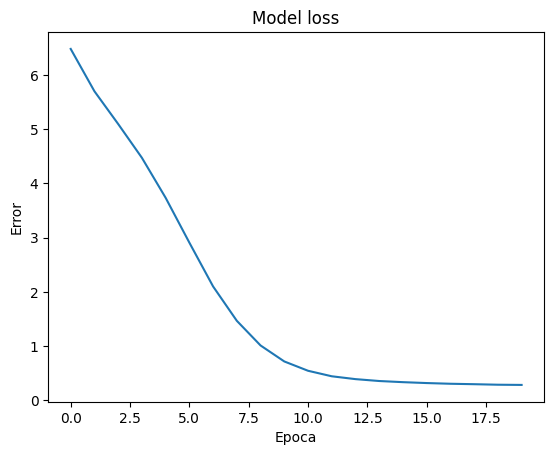

Error final:  0.281522661447525
Precisión final:  0.9242098331451416


In [11]:
# Graficamos el error
plt.plot(model.history.history['loss'])
plt.title('Model loss')
plt.ylabel('Error')
plt.xlabel('Epoca')
plt.show()

# Mostramos el ultimo error
print('Error final: ', model.history.history['loss'][-1])

# Mostramos la precisión
print('Precisión final: ', model.history.history['accuracy'][-1])

In [12]:
# Creamos una función que nos permita predecir la siguiente palabra/s basandonos en una frase
def predict_next_word(n_words, sentence):
    for _ in range(n_words):
        # Convertimos la frase en una secuencia de enteros
        sequence = tokenizer.texts_to_sequences([sentence])[0]

        # Rellenamos la secuencia para que tenga la misma longitud que las demás
        sequence = pad_sequences([sequence], maxlen=max_len-1, padding='pre')

        # Predecimos la siguiente palabra
        # Nota: np.argmax nos permite obtener el índice del valor máximo, o sea la palabra con mayor probabilidad
        predicted = np.argmax(model.predict(sequence), axis=-1)

        # Convertimos el entero en una palabra
        word_predicted = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                word_predicted = word
                break

        # Agregamos la palabra a la frase
        sentence += " " + word_predicted

    return sentence, word_predicted

### Validamos el entrenamiento mediante un texto de prueba.

Del texto de validación el cual es un fragmento del mismo libro del fragmento de entrenamiento, por cada frase se quiere predecir la última palabra y comparar con el texto real.
Se realiza sólo la predicción de la última palabra de cada frase para "ayudar" a la red dándole más contexto de la frase, ya que es difícil que acierte, debido a la cantidad de opciones coherentes que puede predecir.
No necesariamente la palabra predicha es la correcta según el texto, pero pero puede ser coherente con el contexto de la frase, por lo que los resultados de esta validación no son un indicativo real de la calidad del modelo, se requiere un análisis cualitativo.

In [29]:
# Definimos una función para crear las frases que usaremos para entrenar el modelo.
def phrases_to_test(text):
    # Ahora vamos a crear los datos que seran utilizados
    frases = []

    # Unimos todo el texto en una sola linea, para luego separarlo por puntos (.). Esto nos permite tener frases completas.
    texto_unido = text.replace('\n', '.')

    # Separamos el texto por frases (En este caso por puntos)
    for line in texto_unido.split('.'):
        # Aqui vamos a crear frases de 2 palabras, 3 palabras, 4 palabras, etc.
        for i in range(1, len(line.split(' '))):
            sequence = line.split(' ')[:i+1]
            frases.append(' '.join(sequence))
    return frases

# Primero vamos a cargar el texto de prueba
path = './validacion.txt'

# Abrimos el archivo y lo leemos
with open(path, 'r', encoding='utf-8') as f:
    text_prueba = f.read().lower()

# Obtenemos las frases que probaremos
frases_prueba = phrases_to_test(text_prueba)

# Ahora vamos a crear los datos de prueba y las etiquetas
datos_prueba = []
etiquetas_prueba = []

# Separamos las frases en datos y etiquetas
for frase in frases_prueba:
    datos_prueba.append(" ".join(frase.split()[:-1]))
    etiquetas_prueba.append("".join(frase.split()[-1]))

good_predictions = 0

# Ahora vamos a predecir la siguiente palabra de cada frase
for i in range(len(datos_prueba)):

    # Obtenemos la frase a predecir
    frase = datos_prueba[i]

    # Obtenemos la etiqueta
    etiqueta = etiquetas_prueba[i]

    # Predecimos la siguiente palabra
    _, word_predicted = predict_next_word(1, frase)

    # Mostramos la frase
    print('Frase: ', frase)

    # Mostramos la etiqueta
    print('Palabra real: ', etiqueta)

    # Mostramos la frase predicha
    print('Palabra predicha: ', word_predicted)

    # Mostramos un salto de linea
    # print('\n')

    #Calcular precision por palabra
    if etiqueta == word_predicted:
        good_predictions += 1

print('Precisión con respecto al texto de validación: ', good_predictions/len(datos_prueba))

1/1 [==============================] - 0s 20ms/step
Frase:  era
Palabra real:  la
Palabra predicha:  un
1/1 [==============================] - 0s 20ms/step
Frase:  era la
Palabra real:  voz
Palabra predicha:  hora
1/1 [==============================] - 0s 21ms/step
Frase:  era la voz
Palabra real:  del
Palabra predicha:  en
1/1 [==============================] - 0s 19ms/step
Frase:  era la voz del
Palabra real:  alquimista
Palabra predicha:  principiante
1/1 [==============================] - 0s 20ms/step
Frase:  
Palabra real:  el
Palabra predicha:  no
1/1 [==============================] - 0s 19ms/step
Frase:  el
Palabra real:  muchacho
Palabra predicha:  muchacho
1/1 [==============================] - 0s 21ms/step
Frase:  el muchacho
Palabra real:  sonrió
Palabra predicha:  se
1/1 [==============================] - 0s 20ms/step
Frase:  el muchacho sonrió
Palabra real:  y
Palabra predicha:  y
1/1 [==============================] - 0s 18ms/step
Frase:  el muchacho sonrió y
Palabra rea

## Ejemplos de Predicción

Cualitativamente se puede observar que la red neuronal recurrente LSTM es capaz de predecir palabras coherentes con el contexto de la frase, por lo que se considera un éxito.

In [20]:
# Indicamos cuantas palabras queremos predecir
n_palabras = 10

# Indicamos la frase con la que queremos iniciar
frase = "Alejandro dice que"

# Predecimos las palabras
frase, _ = predict_next_word(n_palabras, frase)

print(frase)

1/1 [==============================] - 0s 19ms/step
Alejandro dice que el viejo no apartaba los ojos de su nuevo amigo


In [23]:
# Indicamos cuantas palabras queremos predecir
n_palabras = 15

# Indicamos la frase con la que queremos iniciar
frase = "Sandro dijo que"

# Predecimos las palabras
frase, _ = predict_next_word(n_palabras, frase)

print(frase)

1/1 [==============================] - 0s 19ms/step
Sandro dijo que toda su vida había soñado con ser pastor y que aquello era una buena señal


In [28]:
# Indicamos cuantas palabras queremos predecir
n_palabras = 15

# Indicamos la frase con la que queremos iniciar
frase = "Carlitos pensó que"

# Predecimos las palabras
frase, _ = predict_next_word(n_palabras, frase)

print(frase)

1/1 [==============================] - 0s 20ms/step
Carlitos pensó que si algún día él escribía un libro haría aparecer a los personajes de forma sucesiva
